In [2]:
from tools.dataset import MRCNNLizardDataset
from tools.augmentation import (
    MyColorjitter,
    MyGausssianBlur,
    Random_flip,
    MyRandomCrop,
    MyCenterCrop,
)

data = MRCNNLizardDataset('/home/DM19/workspace/BRBNet/data/Lizard',[
                        MyCenterCrop(256),
                        Random_flip(),
                        MyGausssianBlur(3, sigma=(0.2, 0.3)),
                        MyColorjitter(0.08, 0.08, 0.08, 0.08),
                    ],)


Reading csv file and loading data into memory...
Finish spliting and loading data into memory


tensor(0.9449) tensor(0.0223)
torch.Size([2, 256, 256])
tensor(1) tensor(0)
tensor(6, dtype=torch.uint8) tensor(2, dtype=torch.uint8)


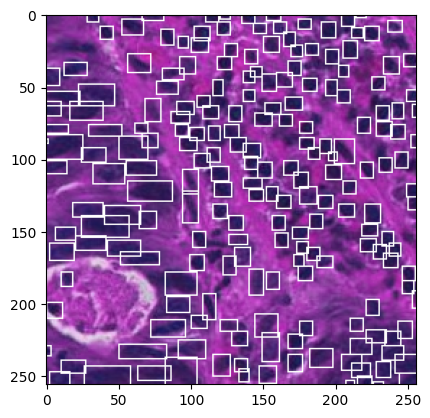

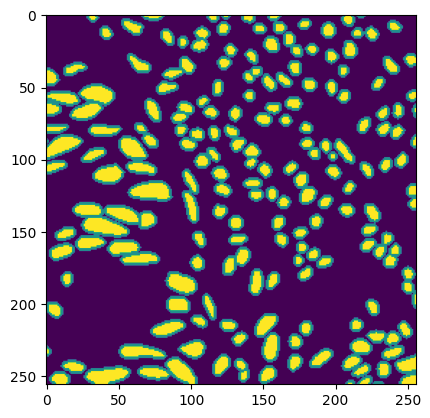

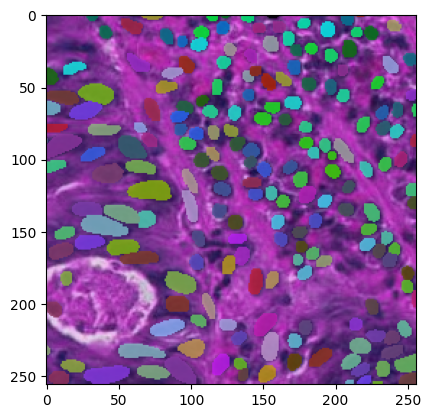

In [6]:
from torchvision.utils import draw_bounding_boxes,draw_segmentation_masks
import torch
import matplotlib.pyplot as plt
from model.MaskRCNN_utils import _do_paste_mask

img, label ,boxes,masks,cls ,semantic_map=data[2]
print(img.max(),img.min())
print(label.shape)
print(masks.max(),masks.min())
print(cls.max(),cls.min())

pic = draw_bounding_boxes((img*255).to(dtype=torch.uint8),boxes)
plt.imshow(pic.permute(1,2,0))
plt.show()
plt.imshow(semantic_map)
plt.show()

pic_mask =_do_paste_mask(masks,boxes,256,256).bool()
pic_mask =draw_segmentation_masks((img*255).to(dtype=torch.uint8),pic_mask)
plt.imshow(pic_mask.permute(1,2,0))
plt.show()




tensor(218) tensor(736)
torch.Size([71680])
torch.Size([71680, 4])
tensor(1.) tensor(-1.)
torch.Size([57344, 4])
[{'pred_bbox': tensor([[ 61.0000, 119.0624,  70.0000, 129.0624],
        [127.9165, 234.2794, 143.9165, 254.2794],
        [ 23.9165,  10.0086,  31.9165,  26.0086],
        ...,
        [102.9987,  81.0838, 121.9987,  99.0838],
        [ 56.0857,  94.0431,  64.0857, 104.0431],
        [239.5451, 136.2769, 247.5451, 142.2769]]), 'scores': tensor([0.7311, 0.7311, 0.7311, 0.7311, 0.7311, 0.7311, 0.7311, 0.7311, 0.7311,
        0.7311, 0.7311, 0.7311, 0.7311, 0.7311, 0.7311, 0.7311, 0.7311, 0.7311,
        0.7311, 0.7311, 0.7311, 0.7311, 0.7311, 0.7311, 0.7311, 0.7311, 0.7311,
        0.7311, 0.7311, 0.7311, 0.7311, 0.7311, 0.7311, 0.7311, 0.7311, 0.7311,
        0.7311, 0.7311, 0.7311, 0.7311, 0.7311, 0.7311, 0.7311, 0.7311, 0.7311,
        0.7311, 0.7311, 0.7311, 0.7311, 0.7311, 0.7311, 0.7311, 0.7311, 0.7311,
        0.7311, 0.7311, 0.7311, 0.7311, 0.7311, 0.7311, 0.7311, 0.7

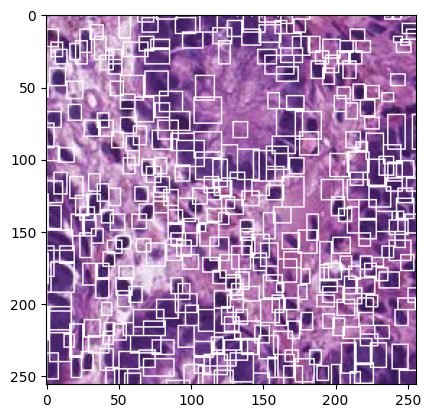

tensor([248,   0,  70,  58,   2,   2,  29])


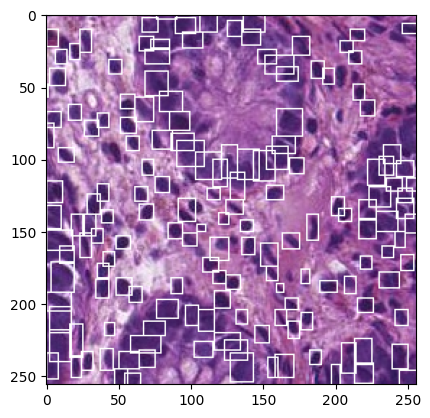

torch.Size([0, 4])
torch.Size([0, 28, 28])
torch.Size([0, 256, 256])


IndexError: list index out of range

In [9]:
from model.GeneralizedRCNN import MRCNN,RPN_, apply_box_delta
from Config.mrcnn_configs import MRCNNConfig1,AnchorWH
from torch.cuda.amp import autocast, GradScaler
from model.MaskRCNN_utils import _do_paste_mask
from torchvision.utils import draw_segmentation_masks,draw_bounding_boxes


arg = MRCNNConfig1('conic','cpu',AnchorWH)

net = MRCNN(
            anchors=arg.anchor_wh.to(arg.device),
            backbone=arg.BACKBONE,
            bottom_up=arg.BOTTOM_UP,
            proposal_generator=arg.PROPAOSAL_GENERATOR,
            stride=arg.STRIDE,
            rpn_pos_threshold=arg.RPN_POS_THRESHOLD,
            rpn_fraction_ratio=arg.RPN_FRACTION_RATIO,
            nms_threshold=arg.NMS_THRESHOLD,
            pre_nms_k=arg.PRE_NMS_K,
            post_nms_k=arg.POST_NMS_K,
            roi_head=arg.ROI_HEAD,
            box_detection=arg.BOX_DETECTION,
            expand=arg.EXPAND,
            expand_ratio=arg.EXPAND_RATIO,
            use_gt_box=arg.USE_GT_BOX,
            roi_resolution=arg.ROI_RESOLUTION,
            stage2_max_proposal=arg.STAGE2_MAX_PROPOSAL,
            stage2_sample_ratio=arg.STAGE2_SAMPLE_RATIO,
            box_weight=arg.BOX_WEIGHT,
            roi_pos_threshold=arg.ROI_POS_THRESHOLD,
            post_decttion_score_threshold=arg.POST_DETECTION_SCORE_THRESHOLD,
            detection_per_img=arg.DETECTION_PER_IMG,
            num_classes=arg.NUM_CLASSES,
            use_semantic=arg.USE_SEMANTIC,
            seg_stride=arg.SEG_STRIDE,
            fuse_feature=arg.FUSE_FEATURE,
        )



target = net.proposal_generator.generate_rpn_targets([boxes])
l=target["target_logist"]
print(torch.sum(l==1),torch.sum(l==0))
r =target["target_reg"]
print(l[0].shape)
print(r[0].shape)


l = list(l[0].split(57344,-1))
l[0] = l[0].reshape(1,14,64,64)
print(l[1].max(),  l[1].min())
l[1] = l[1].reshape(1,14,32,32)
r = list(r[0].split(57344,dim=0))
print(r[0].shape)
r[0] = r[0].reshape(1,14,64,64,4).permute(0,4,1,2,3)
r[1] = r[1].reshape(1,14,32,32,4).permute(0,4,1,2,3)

out =net.proposal_generator.output_proposal(l,r)
print(out)
box_pic = draw_bounding_boxes((img*255).to(dtype=torch.uint8),out[0]['pred_bbox'])
plt.imshow(box_pic.permute(1,2,0))
plt.show()

from model.MaskRCNN_utils import generate_detection_targets
cls2,reg2,masks2 = generate_detection_targets([out[0]['pred_bbox']],target_boxes=[boxes],target_cls=[cls],target_masks=[masks],out_size=28,iou_thresh=0.3)
print(torch.bincount(cls2[0]))

box_pic = draw_bounding_boxes((img*255).to(dtype=torch.uint8),out[0]['pred_bbox'][cls2[0]!=0])

plt.imshow(box_pic.permute(1,2,0))
plt.show()


net.load_state_dict(torch.load('/home/DM19/workspace/BRBNet/model_para/MRCNNConfig1_mode3/1_set_best.pth'))
net.eval()

with autocast():
    preds, metircs =net(img.unsqueeze(0).to(arg.device),[boxes],[masks],[cls],semantic_map.unsqueeze(0).to(arg.device))
    boxes = preds['pred_boxes'][0]
    print(boxes.shape)
    scores = preds['scores'][0]
    masks = preds['pred_masks'][0]
    print(masks.shape)
    classes = preds['pred_classes'][0]
    out=_do_paste_mask(masks,boxes,256,256).bool()
    print(out.shape)
    box_pic = draw_bounding_boxes((img*255).to(dtype=torch.uint8),boxes)
    mask_pic = draw_segmentation_masks((img*255).to(dtype=torch.uint8),out)
    plt.imshow(box_pic.permute(1,2,0))
    plt.show()
    plt.imshow(mask_pic.permute(1,2,0))
    plt.show()
 



In [6]:
from torch.nn.functional import binary_cross_entropy,binary_cross_entropy_with_logits
import torch

a = torch.randn(1,2,3,3)
b = torch.ones(1,2,3,3)

l1=binary_cross_entropy_with_logits(a,b,reduction='none')
l2=binary_cross_entropy(torch.sigmoid(a),b,reduction='none')
print(l1,l2)
print(torch.exp(-l1),torch.exp(-l2))

tensor([[[[3.5449, 0.6103, 1.6332],
          [0.4660, 0.7352, 1.5235],
          [1.4602, 0.5629, 0.4337]],

         [[1.1056, 0.8025, 0.1488],
          [0.6852, 0.4270, 1.6850],
          [0.4502, 2.2289, 1.3939]]]]) tensor([[[[3.5449, 0.6103, 1.6332],
          [0.4660, 0.7352, 1.5235],
          [1.4602, 0.5629, 0.4337]],

         [[1.1056, 0.8025, 0.1488],
          [0.6852, 0.4270, 1.6850],
          [0.4502, 2.2289, 1.3939]]]])
tensor([[[[0.0289, 0.5432, 0.1953],
          [0.6275, 0.4794, 0.2179],
          [0.2322, 0.5696, 0.6481]],

         [[0.3310, 0.4482, 0.8617],
          [0.5040, 0.6525, 0.1854],
          [0.6375, 0.1076, 0.2481]]]]) tensor([[[[0.0289, 0.5432, 0.1953],
          [0.6275, 0.4794, 0.2179],
          [0.2322, 0.5696, 0.6481]],

         [[0.3310, 0.4482, 0.8617],
          [0.5040, 0.6525, 0.1854],
          [0.6375, 0.1076, 0.2481]]]])
